# Machine Learning - Assignment 1

## Naive Bayes Learning algorithm, Cross-validation, and ROC-Curves

The aim of the assignment is to implement:

* Naive Bayes learning algorithm for binary classification tasks
* Visualization to plot a ROC-curve
* A cross-validation test
* Visualization of the average ROC-curve of a cross-validation test

Follow the instructions and implement what is missing to complete the assignment. Some functions have been started to help you a little bit with the inputs or outputs of the function.

**Note:** You might need to go back and forth during your implementation of the code. The structure is set up to make implementation easier, but how you return values from the different functions might vary, and you might find yourself going back and change something to make it easier later on.

## Assignment preparations

We help you out with importing the libraries and reading the data.

Look at the output to get an idea of how the data is structured.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from math import e, pi, sqrt

data = pd.read_csv("iris.csv").to_numpy()

mapped, index, unique_arr = np.unique(data[:, -1], return_index=True, return_inverse=True)
data[:, -1] = unique_arr
iris_setosa, iris_versicolor, iris_virginica = np.split(data, index[1:])

print(f"Full data array (features and labels):\n{iris_setosa[:3]}\n")
print("###############\n")
print(f"Train features (first 4 columns):\n{iris_setosa[:3, :-1]}\n")
print(f"Labels (last column):\n{iris_setosa[:3, -1:]}\n")
print(f"Names of labels:\n{[[numb, name] for numb, name in enumerate(mapped)]}")

Full data array (features and labels):
[[5.1 3.5 1.4 0.2 0]
 [4.9 3.0 1.4 0.2 0]
 [4.7 3.2 1.3 0.2 0]]

###############

Train features (first 4 columns):
[[5.1 3.5 1.4 0.2]
 [4.9 3.0 1.4 0.2]
 [4.7 3.2 1.3 0.2]]

Labels (last column):
[[0]
 [0]
 [0]]

Names of labels:
[[0, 'Iris-setosa'], [1, 'Iris-versicolor'], [2, 'Iris-virginica']]


In [2]:
index

array([  0,  50, 100])

In [3]:
# Example print of the 3 first datapoints (similar as above):
iris_setosa[:3]

array([[5.1, 3.5, 1.4, 0.2, 0],
       [4.9, 3.0, 1.4, 0.2, 0],
       [4.7, 3.2, 1.3, 0.2, 0]], dtype=object)

## Data handling functions

As a start, we are going to implement some basic data handling functions to use in the future.

### 1) Split class into a train and test set

First, we need to be able to split the class into a train and test set.

In [4]:
from typing import Tuple

In [5]:
def train_test_split(class_data: np.ndarray, perc: float = 0.8) -> Tuple[np.ndarray, np.ndarray]:
    
    # TODO: Split the data into two parts, train and test.
    # Numpy has some functionallity that makes implementing this part easier.

    np.random.shuffle(class_data)

    split_idx = round(data.shape[0]*(perc))

    train = class_data[:split_idx]
    test  = class_data[split_idx:] 

    return train, test

train, test = train_test_split(data)

In [6]:
# TODO: Test the train_test_split function
train, test = train_test_split(data)

# TODO: Print the output
print(train.shape[0] / 150)
print(test.shape[0] / 150)

0.8
0.2


In [7]:
print(train.shape[0])

120


### 2) Split data into features and labels

The data as shown above is not always the optimal shape. To help us keep track of things, we can split the data into its features and labels seperately.

Each class is 4 features and 1 label in the same array: 

* **[feature 1, feature 2, feature 3, feature 4, label]**

It would help us later to have the features and labels in seperate arrays in the form: 

* **[feature 1, feature 2, feature 3, feature 4]** and **[label]**

Here you are going to implement this functionallity.

In [8]:
def class_split(data:np.ndarray) -> Tuple[Tuple[np.ndarray, np.ndarray], ...]:

    class_splits = []
    for label in np.unique(data[:, -1]):
        class_data = data[data[:, -1] ==  label]
        features = class_data[:, :-1].astype(np.float64)
        labels = class_data[:, -1].astype(np.float64)
        class_splits.append((features, labels))

    return class_splits

We should first test the "**class_split**" function on one of the classes above (iris_setosa, etc...) to make sure it works properly.

In [9]:
class_splits = class_split(train)
X0_features, y0_labels = class_splits[1]

We should also try to **1)** first split a class into a train and test set, **2)** split each of these two into features and abels. In total there should be 4 arrays (2 feature and 2 label arrays).

In [10]:
class_splits = class_split(train)
X0_features, y0_labels = class_splits[0]
print(f"Feature | Type: {X0_features.dtype} | Shape: {X0_features.shape}")
print(f"Target | Type: {y0_labels.dtype} | Shape: {y0_labels.shape}")

Feature | Type: float64 | Shape: (42, 4)
Target | Type: float64 | Shape: (42,)


Think a bit before going to the next task, what can easily go wrong in the above code?

## Naive Bayes learning algorithm

When implementing the Navie Bayes learning algorithm, we can break it down into a few components.

We will implement these components one at a time.

### 3) Calculate feature statistics

First, we need to implement a function that returns feature statistics (means, standard deviation, priors) for a given set of feature data for a single class. This is the equivalent of "training" the naive bayes model.

**Note 1:** Each feature gets its own mean and standard deviation!

**Note 2:** The way you structure the functions (what is returned) shapes the remainder of the assignment.

In [11]:
print(X0_features.dtype)

float64


In [12]:
def calculate_prior(class_training_data, all_training_data):
    return class_training_data.shape[0] / all_training_data.shape[0]

In [13]:
def calculate_feature_statistics(feature_data: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    features_mean = np.mean(feature_data, axis=0)  
    features_std = np.std(feature_data, axis=0)    
    return features_mean, features_std

In [14]:
means, stds = calculate_feature_statistics(X0_features)

In [15]:
print(means.dtype)

float64


To make sure the function works, we should test it before proceding.

### 4) Gaussian probability density function (Gaussian PDF)

Now we need to implement the gaussian probability density function to use for a single datapoint.

**Note:** Look at the imports in the first cell at the top, it has some math numbers for easy use here. 

In [16]:
def gaussian_probability_density_function(x, means, stdevs):

    if np.any(stdevs <= 0):
        raise ValueError("Stand Deviation MUST be > 0")

    C =  1 / (stdevs * sqrt(2*pi))
    exp = -0.5 * (((x - means) / (stdevs)) ** 2)
    prob_density = C*e**(exp)
    
    return prob_density

### 5) Testing Gaussian PDF

We should test it to make sure it works. Train it, using the "calculate_feature_statistics" function, on one of the dataset classes. Then, take one datapoint from the same class and use naive bayes gaussian to make a prediction.

In [17]:
# TODO: Implement the code below to test the "gaussian_probability_density_function" function for one of the classes.
means, stddevs = calculate_feature_statistics(X0_features)

# TODO: Test with one datapoint from the learned class.
# x = test[np.random.randint(test.shape[0])] # random
y0_test = test[test[:,-1] == 0] # from same class, i.e., 0
x = y0_test[np.random.randint(y0_test.shape[0])]
print("Same Class datapoint: ", x)
prob_density = gaussian_probability_density_function(x[:-1], means[x[-1]], stddevs[x[-1]])

# TODO: Print the probability density
print(prob_density)
print(np.prod(prob_density))

Same Class datapoint:  [5.0 3.5 1.6 0.6 0]
[1.1618748769908813 3.16804264633902e-05 3.2077200534376625e-23
 3.5703729818493166e-38]
4.215610008311821e-65


As a test, take one datapoint from one of the other classes and see if the predicted probability changes.

In [18]:
# TODO: Take one datapoint from one of the other classes.
y0_test = test[test[:,-1] != 0] # from same class, i.e., 0
other_class_datapoint = y0_test[np.random.randint(y0_test.shape[0])]
print("Other Class datapoint: ", other_class_datapoint)

# TODO: Use naive bayes gaussian on this datapoint with the same feature statistics as the first class.
prob_density = gaussian_probability_density_function(other_class_datapoint[:-1], means[x[-1]], stddevs[x[-1]])

# TODO: Print the probability
print(np.prod(prob_density))

Other Class datapoint:  [5.7 2.9 4.2 1.3 1]
4.823610576380734e-38


Think a bit why the probability changes, what could affect the prediction?

- The feature probabilities given the target class, are rather stable between testpoints, given that the test point is choosen from the same class. Given that we have a flower, say, 'Iris-setosa', then each of the features generally tend to be alike between samples. One of them will dominate more than others. This domination will be similar for test points from the same type of flower, since the features varies in a similar way like for the training points, as they belong to the same flower. However, if we keep the same joint distribution but change the incoming datapoint, such that it belongs to another class and has other means/stddevs, then also will the feature distributions for each point vary more chaotically.

## Prepare Naive Bayes for binary classification

### 6) Prepare the data for inference

Before we train and test the naive bayes for multiple classes, we should get our data in order.

Similar to how we did previously, we should now split two classes into a train and test set, you may choose which two classes freely.

In [19]:
# TODO: Split two classes into train and test sets.
X0_features, y0_labels = class_splits[0]

# TODO: Sepearte the features and lables for both the train and test set.
X2_features, y2_labels = class_splits[2]

### 7) Class A vs Class B for binary classification

**Note:** You might need to go back and forth a bit in the following cells during your implementation of your code.

We have to get the probability from two sets of classes and compare the two probabilities in order to make a propper prediction.

Here we will implement two functions to make this possible. We seperate these functions to make the implementation of the ROC-curve easier later on.

**Function 1: naive_bayes_prediction** 
* A function that returns the probabilities for each class the model for a single datapoint.

**Function 2: probabilities_to_prediction**
* A function that takes in probabilities and returns a prediction.

In [161]:
def probabilities_to_prediction(likelihoods):
    return np.argmax(likelihoods), likelihoods[0]  

In [168]:
def naive_bayes_prediction(feature_stats, data_point):

    # TODO: Implement the rest of this function. Make use of previous functions that you have implemented.
    # NOTE: Multiplying by P(Y) does not change the answer since each class has P(Y) = 1/3
    prediction_likelihoods = []
    for feature_set in feature_stats:
        means, stddevs, prior = feature_set
        prediction_likelihoods.append(np.prod(gaussian_probability_density_function(data_point, means, stddevs)) * prior)

    # Normalize to get probabilities for each class
    epsilon = 1e-10
    probabilities = [max(likelihood / sum(prediction_likelihoods), epsilon) for likelihood in prediction_likelihoods]

    # Note: We need to compare the probabilities at some point between the classes we test on, the predicted class should be the class with the highest probability.
    return probabilities

In [129]:
def predict_all(data):
    # NOTE: The actual values are found in y_target
    class_predictions = []
    prob_of_class_predictions = []
    class_actual_labels = []
    feature_stats = []
    
    train, test = train_test_split(data)
    test_class_splits = class_split(test)
    train_class_splits = class_split(train)

    # calculate feature stats
    for y in np.unique(data[:,-1]):
        train_class_split = train_class_splits[y]    
        train_features, train_target =  train_class_split
        means, stddevs = calculate_feature_statistics(train_features)
        prior = calculate_prior(train_target, train)
        feature_stats.append((means, stddevs, prior))

    # input: feature stats and a training data
    # output: naive-bayes accuracy
    for y in np.unique(data[:,-1]):
        test_class_split = test_class_splits[y]    
        test_features, test_target =  test_class_split
        class_actual_labels.extend(test_target)
        for x in test_features:
            probabilities = naive_bayes_prediction(feature_stats, x)
            predicted_test_class, prob_of_class_prediction = probabilities_to_prediction(probabilities)
            class_predictions.append(predicted_test_class)
            prob_of_class_predictions.append(prob_of_class_prediction)

    # accuracy
    class_actual_labels = np.array(class_actual_labels).astype(np.float64)
    class_predictions = np.array(class_predictions).astype(np.float64)
    print('Accuracy', np.mean(class_actual_labels == class_predictions) * 100)
    return class_actual_labels, class_predictions, prob_of_class_predictions

Accuracy 100.0
[np.float64(1.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)

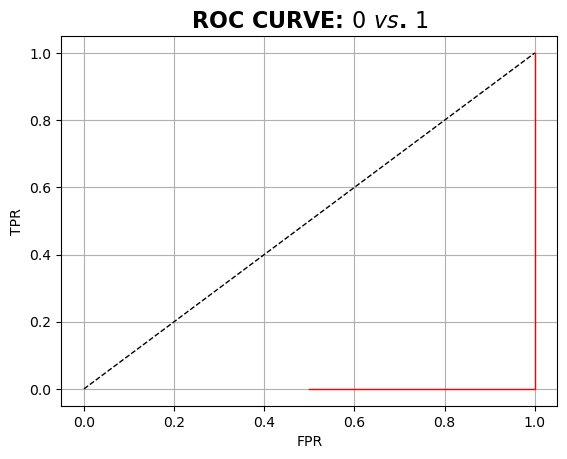

In [171]:
def predict_0_vs_1(data):
    class_predictions = []
    prob_of_class_predictions = []
    class_actual_labels = []
    feature_stats = []

    train, test = train_test_split(data)
    test_class_splits = class_split(test)
    train_class_splits = class_split(train)

    # calculate feature stats
    for y in np.array([0,1]):
        train_class_split = train_class_splits[y]    
        train_features, train_target =  train_class_split
        means, stddevs = calculate_feature_statistics(train_features)
        prior = calculate_prior(train_target, train)
        feature_stats.append((means, stddevs, prior))

    # input: feature stats and a training data
    # output: naive-bayes accuracy
    for y in np.array([0,1]):
        test_class_split = test_class_splits[y]    
        test_features, test_target =  test_class_split
        class_actual_labels.extend(test_target)
        for x in test_features:
            probabilities = naive_bayes_prediction(feature_stats, x)
            predicted_test_class, prob_of_class_prediction = probabilities_to_prediction(probabilities)
            class_predictions.append(predicted_test_class)
            prob_of_class_predictions.append(prob_of_class_prediction)

    # accuracy
    class_actual_labels = np.array(class_actual_labels).astype(np.float64)
    class_predictions = np.array(class_predictions).astype(np.float64)
    print('Accuracy', np.mean(class_actual_labels == class_predictions) * 100)
    return class_actual_labels, prob_of_class_predictions

class_actual_labels, prob_of_class_predictions = predict_0_vs_1(data)


def roc_curve_0_vs_1(class_actual_labels, prob_of_class_predictions):
    step_size = 0.01
    cs = np.arange(0, 1 + step_size, step=step_size)

    TPR_01, FPR_01 = [], []

    for c in cs:
        y_pred_01 = (prob_of_class_predictions >= c).astype(int)
        TP_01 = np.sum((class_actual_labels == 1) & (y_pred_01 == 1))
        FP_01 = np.sum((class_actual_labels == 0) & (y_pred_01 == 1))
        TN_01 = np.sum((class_actual_labels == 0) & (y_pred_01 == 0))
        FN_01 = np.sum((class_actual_labels == 1) & (y_pred_01 == 0))
        TPR_01.append(TP_01 / (TP_01 + FN_01))
        FPR_01.append(FP_01 / (FP_01 + TN_01))
    
    print(TPR_01)
    print(FPR_01)

    plt.plot(cs, cs, color='k', ls='--', lw='1')
    plt.plot(FPR_01, TPR_01, color='r', ls='-', lw='1')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(r"ROC CURVE: $0$ $vs$. $1$", fontsize=16, fontweight='bold')
    plt.grid(True)

roc_curve_0_vs_1(class_actual_labels, prob_of_class_predictions)

## ROC-curve

A ROC curve, or *Receiver Operating Characteristic curve*, is a graphical plot that illustrates the performance of a binary classifier such as our Naive Bayes model.

More info can be found in the course material and here: [https://en.wikipedia.org/wiki/Receiver_operating_characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)

Another good illustration by Google can be found here: [https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)

Now that we have a prediction model, we would want to try it out and test it using a ROC-curve.

- MAHMUTS COMMENT: You want to fine the point in the graph which enables you to have as large TPR (a high fraction of true positive rates correctly classified) as possible whilst keeping the FPR as low as possible (the fraction or negative points incorrectly classified as negative)

In [131]:
def roc_curve_all(data_1_vs_REST, data_2_vs_REST, data_3_vs_REST):
    step_size = 0.01
    cs = np.arange(0, 1 + step_size, step=step_size)

    y_true_AB = np.array(data_1_vs_REST['Actual'])
    y_true_AC = np.array(data_2_vs_REST['Actual'])
    y_true_BC = np.array(data_3_vs_REST['Actual'])

    y_prob_AB = np.array(data_1_vs_REST['Probability'])
    y_prob_AC = np.array(data_2_vs_REST['Probability'])
    y_prob_BC = np.array(data_3_vs_REST['Probability'])

    TPR_AB, FPR_AB = [], []
    TPR_AC, FPR_AC = [], []
    TPR_BC, FPR_BC = [], []

    for c in cs:
        y_pred_AB = (y_prob_AB >= c).astype(int)
        y_pred_AC = (y_prob_AC >= c).astype(int)
        y_pred_BC = (y_prob_BC >= c).astype(int)

        TP_AB = np.sum((y_true_AB == 1) & (y_pred_AB == 1))
        TP_AC = np.sum((y_true_AC == 1) & (y_pred_AC == 1))
        TP_BC = np.sum((y_true_BC == 1) & (y_pred_BC == 1))
        FP_AB = np.sum((y_true_AB == 0) & (y_pred_AB == 1))
        FP_AC = np.sum((y_true_AC == 0) & (y_pred_AC == 1))
        FP_BC = np.sum((y_true_BC == 0) & (y_pred_BC == 1))
        TN_AB = np.sum((y_true_AB == 0) & (y_pred_AB == 0))
        TN_AC = np.sum((y_true_AC == 0) & (y_pred_AC == 0))
        TN_BC = np.sum((y_true_BC == 0) & (y_pred_BC == 0))
        FN_AB = np.sum((y_true_AB == 1) & (y_pred_AB == 0))
        FN_AC = np.sum((y_true_AC == 1) & (y_pred_AC == 0))
        FN_BC = np.sum((y_true_BC == 1) & (y_pred_BC == 0))

        TPR_AB.append(TP_AB / (TP_AB + FN_AB))
        TPR_AC.append(TP_AC / (TP_AC + FN_AC))
        TPR_BC.append(TP_BC / (TP_BC + FN_BC))

        FPR_AB.append(FP_AB / (FP_AB + TN_AB))
        FPR_AC.append(FP_AC / (FP_AC + TN_AC))
        FPR_BC.append(FP_BC / (FP_BC + TN_BC))
    
    _, img = plt.subplots(1, 3, figsize=(15, 5)) 

    img[0].plot(cs, cs, color='k', ls='--', lw='1')
    img[0].plot(FPR_AB, TPR_AB, color='r', ls='-', lw='1')
    img[0].set_xlabel('FPR')
    img[0].set_ylabel('TPR')
    img[0].set_title(r"ROC CURVE: $A$ $vs$. $REST$", fontsize=16, fontweight='bold')
    img[0].grid(True)

    img[1].plot(cs, cs, color='k', ls='--', lw='1')
    img[1].plot(FPR_AC, TPR_AC, color='r', ls='-', lw='1')
    img[1].set_xlabel('FPR')
    img[1].set_ylabel('TPR')
    img[1].set_title(r"ROC CURVE: $B$ $vs$. $REST$", fontsize=16, fontweight='bold')
    img[1].grid(True)

    img[2].plot(cs, cs, color='k', ls='--', lw='1')
    img[2].plot(FPR_BC, TPR_BC, color='r', ls='-', lw='1')
    img[2].set_xlabel('FPR')
    img[2].set_ylabel('TPR')
    img[2].set_title(r"ROC CURVE: $C$ $vs$. $REST$", fontsize=16, fontweight='bold')
    img[2].grid(True)

In [136]:
def softmax(arr: np.ndarray) -> np.array:
    num = e**np.array(arr)
    den = np.sum(e**np.array(arr))
    return num / den

def probabilities_to_prediction(likelihoods):
    # TODO: Implement prediction of the class with the highest likelihood
    return np.argmax(likelihoods), np.max(softmax(likelihoods))

Accuracy 96.66666666666667


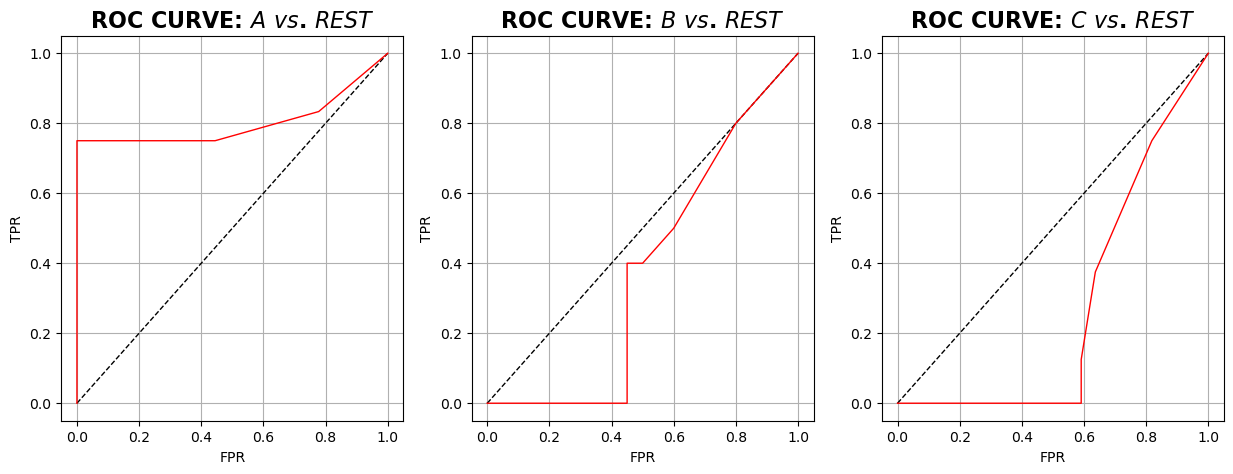

In [135]:
class_actual_labels, class_predictions, prob_of_class_predictions =  predict_all(data)
bayes_all_classes = pd.DataFrame({'Actual': class_actual_labels, 'Bayes_Predicted': class_predictions, 'Probability': prob_of_class_predictions})
data_1_vs_REST = bayes_all_classes.sort_values(by='Probability', axis=0, ascending=False).drop('Bayes_Predicted', axis=1).replace({0:1, 1:0, 2:0})
data_2_vs_REST = bayes_all_classes.sort_values(by='Probability', axis=0, ascending=False).drop('Bayes_Predicted', axis=1).replace({0:0, 1:1, 2:0})
data_3_vs_REST = bayes_all_classes.sort_values(by='Probability', axis=0, ascending=False).drop('Bayes_Predicted', axis=1).replace({0:0, 1:0, 2:1})
roc_curve_all(data_1_vs_REST, data_2_vs_REST, data_3_vs_REST)

### 8) True Positive Rate (TPR) and False Positive Rate (FPR)

From our prediction function we get probabilities, and for prediction purposes we have just predicted the one with the highest probability.

To plot a ROC-curve, we need the TPR and FPR for the binary classification. We will implement this here.

**Note 1:** The threshold is is a value that goes from 0 to 1. 

**Note 2:** One of the two classes will be seen as "the positive class" (prediction over the threshold) and the other as "the negative class" (prediction under the threshold).

**Note 3:** The threshold stepsize will decide the size of the returned TPR/FPR list. A value of 0.1 will give 10 elements (0 to 1 in increments of 0.1)

In [28]:
# Stepsize demonstration
print("Python list:", [x/10 for x in range(0,10,1)])

# Stepsize demonstration with numpy:
print("Numpy linspace:", np.linspace(0,1,11))
print("Numpy linspace (no endpoint):", np.linspace(0,1,10,endpoint=False))

Python list: [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
Numpy linspace: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
Numpy linspace (no endpoint): [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


In [30]:
def TPR_and_FPR(prediction_probabilities, test_labels, threshold_stepsize = 0.1):

    # TODO: Implement the rest of this function


    return TPR, FPR

In [27]:
# TODO: Test the "TPR_and_FPR" function on the model you have created previously.

How does the values change if you change the threshold stepsize? 

How does the values change if you change the classes you compare?

### 9) Plot the TPR and FPR

To better see what is going on, we can plot the TPR and FPR. We can also calculate the Area Under the ROC Curve (AUC or AUROC) at the same time.

In [28]:
def plot_ROC(TPR, FPR):

    # TODO: Calculate the AUC score.

    # TODO: Plot the TPR and FPR using plt (matplotlib)

    # TODO: Add a "middle-line" in the plot. This can be seen as the "better/worse than random" line.

    plt.plot(...)

    plt.show()

    pass # No need to return anything, remove this line once you are finished implementing.

In [29]:
# TODO: Test the plotting function on the TPR and FPR you just calculated.

## Cross-validation

The final task is to take everything you have implemented so far and apply it in a cross-validation loop.

**Note 1:** To better reflect a real scenarios, you should shuffle the data before doing cross-validation.

**Note 2:** When using cross-validation, the interesting thing is the mean performance (mean AUC, mean accuracy, mean ROC-curve).

**Note 3:** This part is a bit more free in terms of implementation, but make sure to use some of the previously implemented functions.

### 10) Cross-validation loop

In [30]:
def cross_validation(data, target, folds = 10, threshold_stepsize = 0.1):

    # TODO: Implement Cross-validation
    
    for i in range(folds):


        ...

    # TODO: Plot the average ROC-curve.
    # NOTE: Take the correct average!

    plot_ROC(...)

### 11) 10-fold Cross-validation on all classes

Test the "cross_validation" function on all the classes against eachother using 10 folds.

* Iris-setosa vs Iris-versicolor
* Iris-setosa vs Iris-virginica
* Iris-versicolor vs Iris-virginica

In [31]:
# TODO: Implement and test cross-validation function on all classes.

In [32]:
# TODO: Implement and test cross-validation function on all classes.

In [33]:
# TODO: Implement and test cross-validation function on all classes.

# Questions for examination:

In addition to completing the assignment with all its tasks, you should also prepare to answer the following questions:

1) Why is it called "naive bayes"?

2) What are some downsides of the naive bayes learning algorithm?

3) When using ROC-curves, what is the theoretical best and worst result you can get?

4) When using ROC-curves, in this assignment for example, is a higher threshold-stepsize always better?  

5) When using cross-validation and ROC-curves, why is it important to take the correct mean values? What could go wrong?


# Finished!

Was part of the setup incorrect? Did you spot any inconsistencies in the assignment? Could something improve?

If so, please write them and send via email and send it to:

* marcus.gullstrand@ju.se

Thank you!